#INFO

**Moutning google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##imports

In [3]:
import pandas as pd
import numpy as np


DDSM_dir = "/content/drive/MyDrive/Project_shared/Datasets/mammography/CBIS-DDSM"

IMAGES = np.load(f'{DDSM_dir}/training/images.npy', allow_pickle=True)
MASKS = np.load(f'{DDSM_dir}/training/masks.npy', allow_pickle=True)

print(IMAGES.shape)
print(MASKS.shape)

(3568, 256, 256, 1)
(3568, 256, 256, 1)


In [4]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

#utils

##**Metrics**

Mean IOU

In [5]:
def iou_coef1(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [6]:
def iou_coef2(y_true, y_pred):
  smooth = K.epsilon() ##
  thr = 0.5 ###
  y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # apply threshold to prediction
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  return K.mean((intersection + smooth) / (union + smooth), axis=0)

Pixel accuracy

In [7]:
def pixel_accuracy(y_true, y_pred):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.round(tf.reshape(y_pred, [-1]))  # round to get 0 or 1 prediction
    
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32))
    total_pixels = tf.cast(tf.size(y_true_f), tf.float32)
    
    return correct_pixels / total_pixels

Pescision and Recall

In [8]:
def recall(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + smooth)
  return recall

def precision(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + smooth)
  return precision

F1 score

In [9]:
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    # Ensure the F1 score is defined even when precision and recall are 0
    if p + r == 0:
        return 0.0

    f1 = 2 * ((p * r) / (p + r))
    return f1

In [10]:
metrics = [iou_coef1,
           iou_coef2,
           #pixel_accuracy,
           recall,
           precision,
           f1]

##**Loss**

especially with class imbalance (which is common in biomedical imaging where the region of interest is often small compared to the entire image), the Dice loss alone may not be the best choice, as it can be biased towards the majority class. 
source : chatgpt

**Dice Loss**

In [11]:
def dice_coef(y_true, y_pred, smooth=.1):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection) / (K.sum(K.square(y_true)) + K.sum(K.square(y_pred)) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [12]:
def dice_loss2(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


**IOU loss**

In [13]:
def iou_loss1(y_true, y_pred):
    return 1 - iou_coef1(y_true, y_pred)

In [14]:
def iou_loss2(y_true, y_pred):
    return 1 - iou_coef2(y_true, y_pred)

**focal loss**

In [15]:
def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss

**combind losses**

In [16]:
#dice loss combind with binary_crossentropy
def loss1(y_true, y_pred):
    binary_crossentropy = keras.losses.binary_crossentropy(y_true, y_pred)
    return binary_crossentropy + dice_loss

In [17]:
#dice coeff and iou coeff loss combind
def loss2(y_true, y_pred):
  return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef1(y_true, y_pred))

##**Optimizers**

In [18]:
def optimizer(lr):
  
  optimizer = optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
  )
  return optimizer

def lr_schedule(initial = 0.01):
  initial_learning_rate = 0.01
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                               decay_steps=100000, 
                                                               decay_rate=0.96, staircase=True
                                                                )
  return lr_schedule

##**callbacks**

In [19]:
def build_callbacks(model_name, patience = 10): 
    callback= [ModelCheckpoint(f'/content/drive/MyDrive/trained_models/U-Net/{model_name}.h5',verbose =1, save_best_only=True),
    EarlyStopping(patience = patience, verbose =1, restore_best_weights=True ,monitor = "val_loss")]
    return callback

#Model architicture

In [20]:
def unet(input_size = (256,256,1) , sart_neurons = 32):
    inputs = Input(input_size)
    conv1 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(sart_neurons * 16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(sart_neurons * 16, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(sart_neurons * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(sart_neurons * 8, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(sart_neurons * 4, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(sart_neurons * 2, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(sart_neurons * 1, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
        
    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[output_layer])
    return model

In [ ]:
model = unet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 15.2 MB/s eta 0:00:00


In [22]:
import visualkeras
visualkeras.layered_view(model,legend=True, draw_volume=True)

NameError: ignored

#**Fitting**

for the trining we will we can change different

 - optimizers
 - losses
 - we can also change the number of nnuerons in our model

##functions

defining a function to train the model of which some parameters we can change

In [ ]:
x_train = None 
x_test = None
y_train = None
y_test = None
x_val = None
y_val = None

In [23]:
def train(name,opt, loss, d_divisor = 1, batch_size = 1 , epochs = 100 , sart_neurons = 32 , verbose = 0, patience = 35):
  # optimizor
  # loss
  # data divisor is used to make the data smaller d_divisor = 1 mean it's the largest data
  global x_train, x_test, y_train, y_test, x_val, y_val

  #spliting the data
  IMAGES_sub = np.split(IMAGES, d_divisor)[0] 
  MASKS_sub = np.split(MASKS, d_divisor)[0] 

  # Split dataset into train and test sets (80/20 split)
  x_train, x_test, y_train, y_test = train_test_split(IMAGES_sub, MASKS_sub, test_size=0.2, random_state=42)

  # Split training set into train and validation sets (80/20 split)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

  # the model needs the mask to be floating point
  y_train = y_train.astype('float32')
  y_val = y_val.astype('float32')

  #model compilation
  model = unet(sart_neurons = sart_neurons)
  model.compile(opt, loss=loss, metrics=metrics)

  train_steps = x_train.shape[0] // batch_size
  test_steps = x_val.shape[0] // batch_size


  print("\n Model is training") 

  history = model.fit(x=x_train, 
                      y=y_train, 
                      epochs=epochs,
                      steps_per_epoch = train_steps, 
                      validation_steps= test_steps ,
                      callbacks = build_callbacks(name,patience),
                      batch_size = batch_size, 
                      validation_data=(x_val, y_val),
                      shuffle=False,
                      verbose = verbose)
  
  print("\n Model history")
  
  plot_history(history)

  print("\n ====================================================")
  print("\n predicting on a test set") 

  pred = model.predict(x_test)

  print("\n plotting a sample of the predicted output")
  plot_prediction(pred)

  return model , history

**Function to plot the history**

In [24]:
def plot_history(history):
    metrics = [key for key in history.history.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    num_cols = 3
    num_rows = math.ceil(num_metrics / num_cols)

    plt.figure(figsize=(12, 4 * num_rows))
    
    for i, metric in enumerate(metrics):
        plt.subplot(num_rows, num_cols, i+1)
        
        plt.plot(history.history[metric])
        if 'val_'+metric in history.history.keys():
            plt.plot(history.history['val_'+metric])
        
        plt.title('Model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

function to plot a random sample

In [25]:
def plot_image(img):
  plt.imshow(img.reshape(256,256), interpolation='nearest')
  plt.show()
  return plt

def plot_prediction(y_pred, num_samples=5):
    # Choose random indices
    indices = np.random.choice(np.arange(y_pred.shape[0]), size=num_samples, replace=False)
    
    for idx in indices:
        # Get data
        x = x_test[idx]
        true = y_test[idx] # true mask
        pred = y_pred[idx]
        binary_pred = np.where(pred > 0.5, 1, 0) #pred after post proccessing


        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        # Plot original image
        axs[0].imshow(x, cmap='gray')
        axs[0].set_title("Original Image")

        # Plot prediction
        axs[1].imshow(pred.squeeze(), cmap='gray')
        axs[1].set_title("Predicted")

        # Plot binary prediction
        axs[2].imshow(binary_pred.squeeze(), cmap='gray')
        axs[2].set_title("Binary Predicted")


        # Plot ground truth
        axs[3].imshow(true.squeeze(), cmap='gray')
        axs[3].set_title("Ground Truth")


        # Hide the axes
        for ax in axs:
            ax.axis('off')

        plt.show()

##using dice loss

optimizer adam(lr = 0.001)



 Model is training

Epoch 1: val_loss improved from inf to 0.88085, saving model to /content/drive/MyDrive/trained_models/U-Net/dice_opt1.h5

Epoch 2: val_loss did not improve from 0.88085

Epoch 3: val_loss did not improve from 0.88085

Epoch 4: val_loss did not improve from 0.88085

Epoch 5: val_loss improved from 0.88085 to 0.82368, saving model to /content/drive/MyDrive/trained_models/U-Net/dice_opt1.h5

Epoch 6: val_loss did not improve from 0.82368

Epoch 7: val_loss improved from 0.82368 to 0.79012, saving model to /content/drive/MyDrive/trained_models/U-Net/dice_opt1.h5

Epoch 8: val_loss did not improve from 0.79012

Epoch 9: val_loss improved from 0.79012 to 0.78264, saving model to /content/drive/MyDrive/trained_models/U-Net/dice_opt1.h5

Epoch 10: val_loss did not improve from 0.78264

Epoch 11: val_loss did not improve from 0.78264

Epoch 12: val_loss did not improve from 0.78264

Epoch 13: val_loss improved from 0.78264 to 0.78035, saving model to /content/drive/MyDrive/

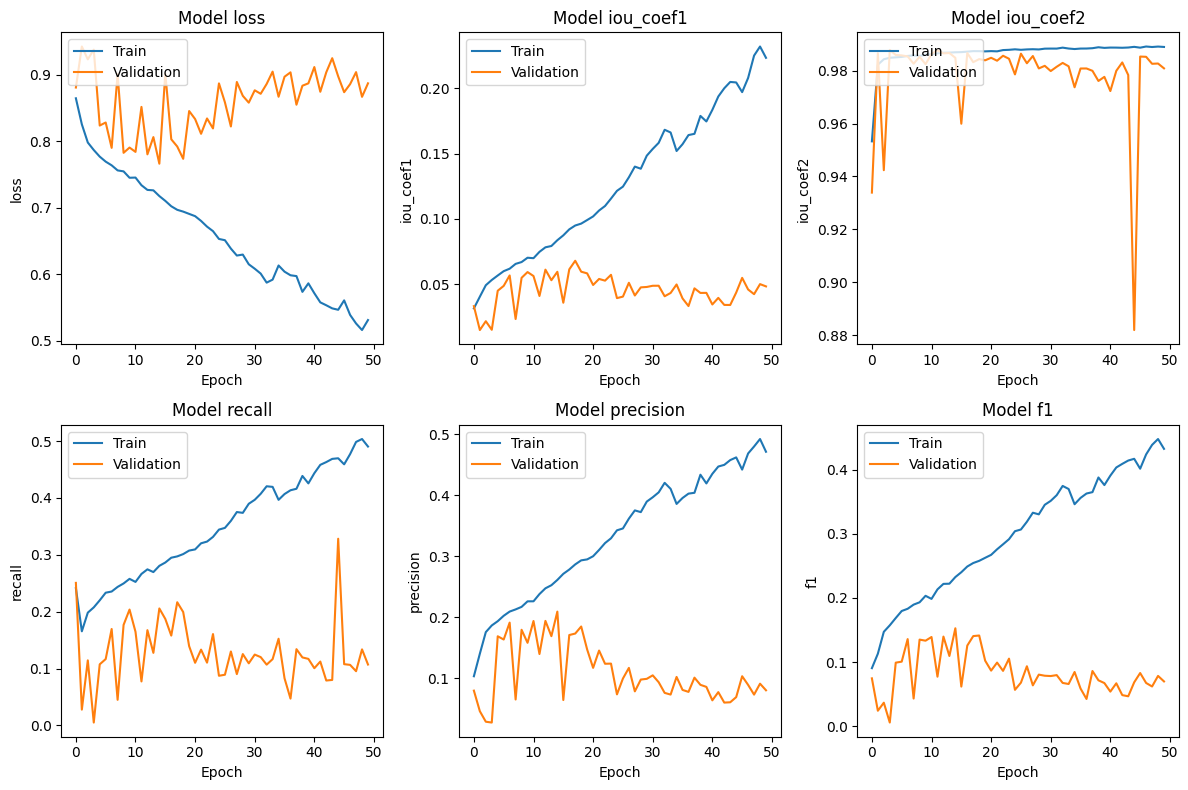



 predicting on a test set
23/23 [==============================] - 12s 261ms/step

 plotting a sample of the predicted output


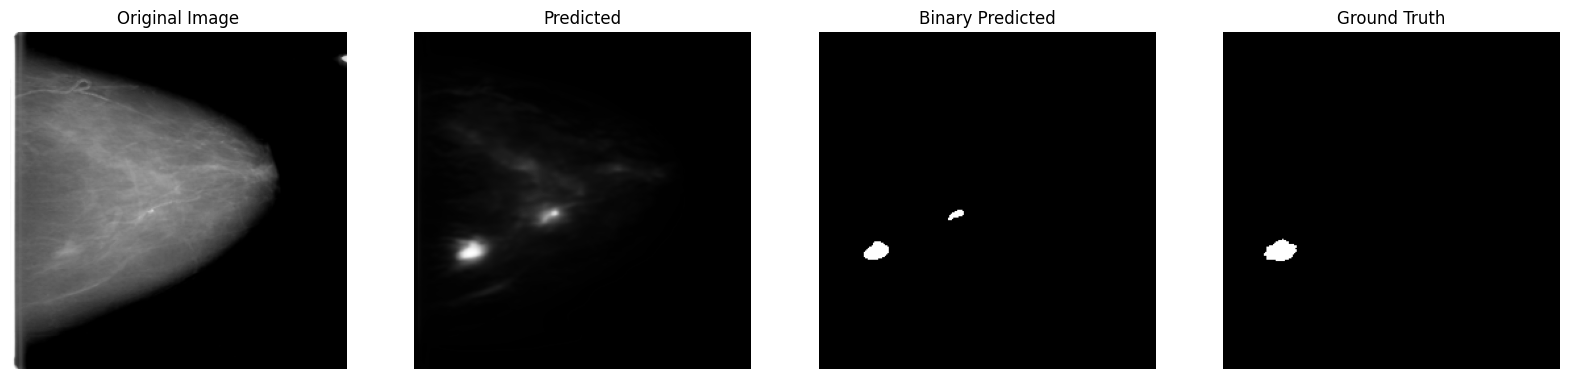

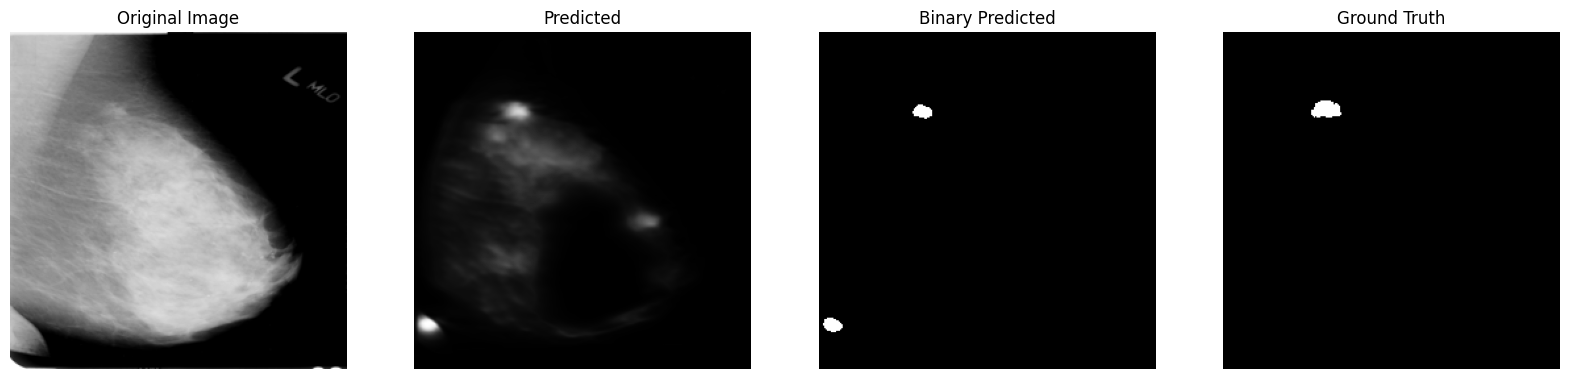

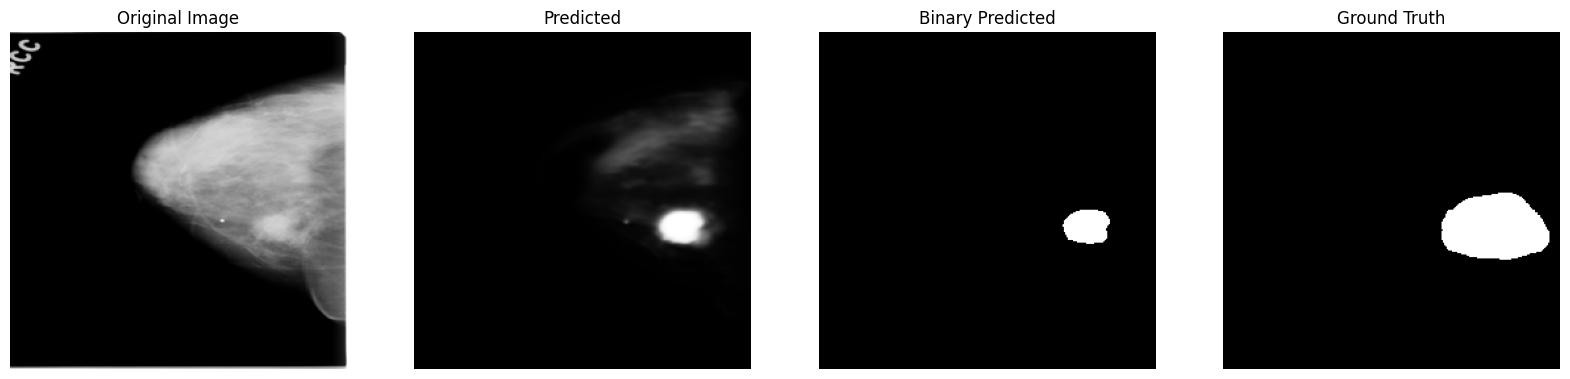

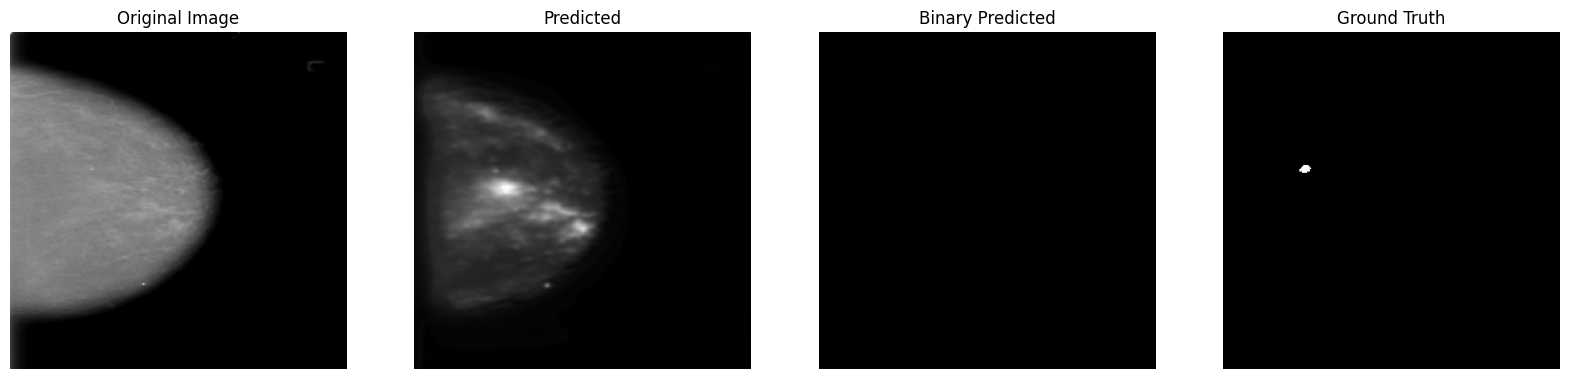

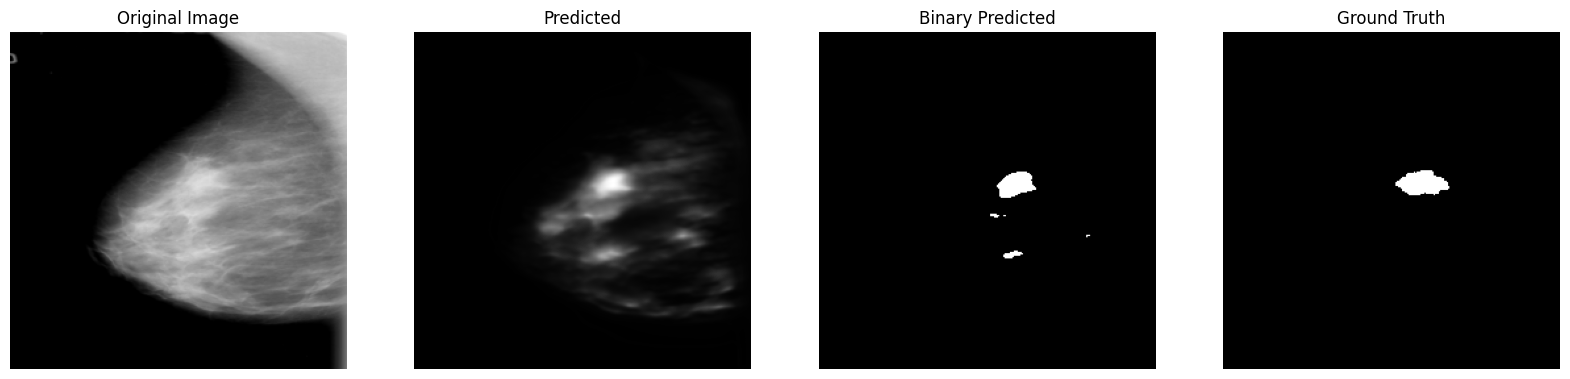

(<keras.engine.functional.Functional at 0x7fbf596888e0>,
 <keras.callbacks.History at 0x7fbf59776710>)

In [ ]:
train("dice_opt1",opt = optimizer(0.001), loss = dice_loss)

optimizer adam(lr = learning schedual)


 Model is training

Epoch 1: val_loss improved from inf to 0.91533, saving model to /content/drive/MyDrive/trained_models/U-Net/dice_opt2.h5

Epoch 2: val_loss did not improve from 0.91533

Epoch 3: val_loss improved from 0.91533 to 0.84636, saving model to /content/drive/MyDrive/trained_models/U-Net/dice_opt2.h5

Epoch 4: val_loss improved from 0.84636 to 0.81954, saving model to /content/drive/MyDrive/trained_models/U-Net/dice_opt2.h5

Epoch 5: val_loss did not improve from 0.81954

Epoch 6: val_loss did not improve from 0.81954

Epoch 7: val_loss did not improve from 0.81954

Epoch 8: val_loss did not improve from 0.81954

Epoch 9: val_loss improved from 0.81954 to 0.81331, saving model to /content/drive/MyDrive/trained_models/U-Net/dice_opt2.h5

Epoch 10: val_loss did not improve from 0.81331

Epoch 11: val_loss did not improve from 0.81331

Epoch 12: val_loss did not improve from 0.81331

Epoch 13: val_loss did not improve from 0.81331

Epoch 14: val_loss did not improve from 0.8

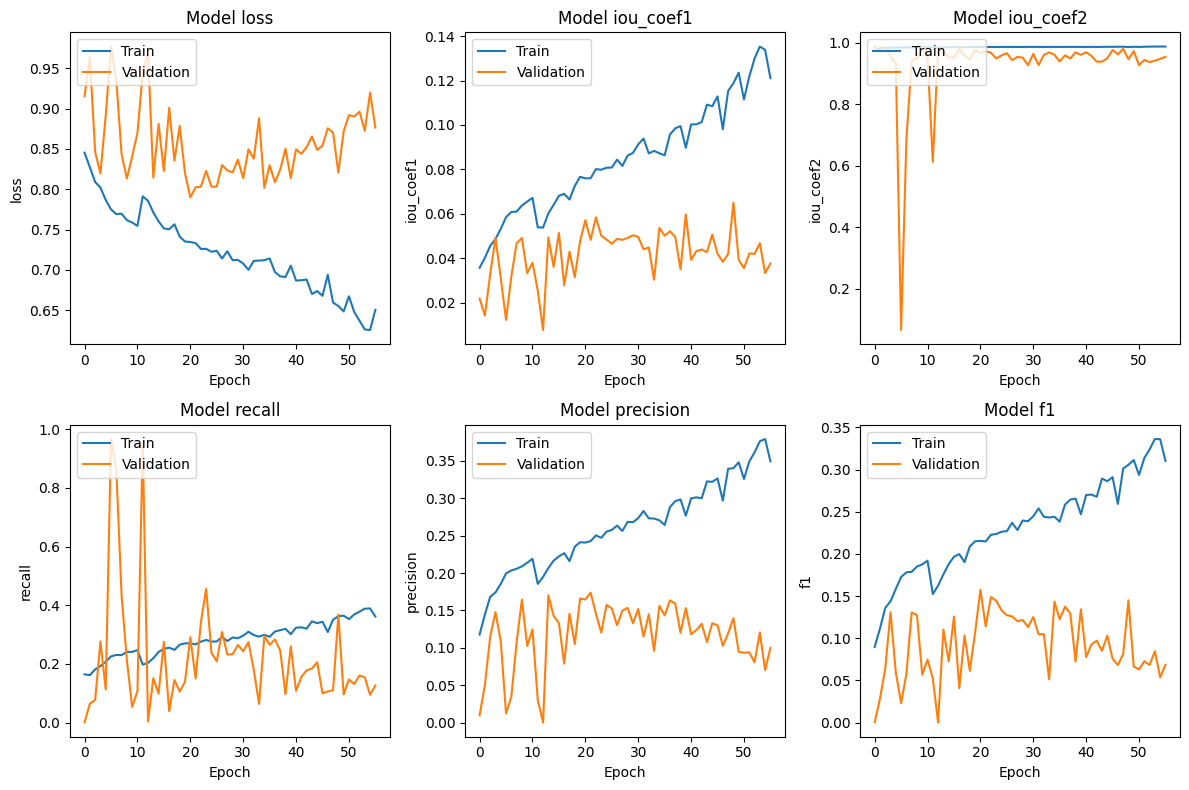



 predicting on a test set
23/23 [==============================] - 4s 165ms/step

 plotting a sample of the predicted output


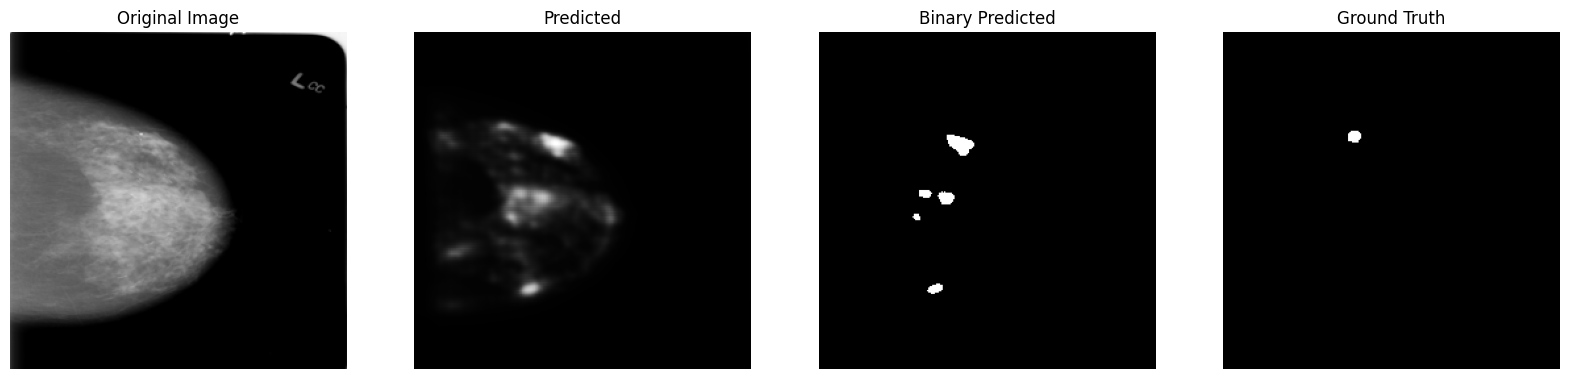

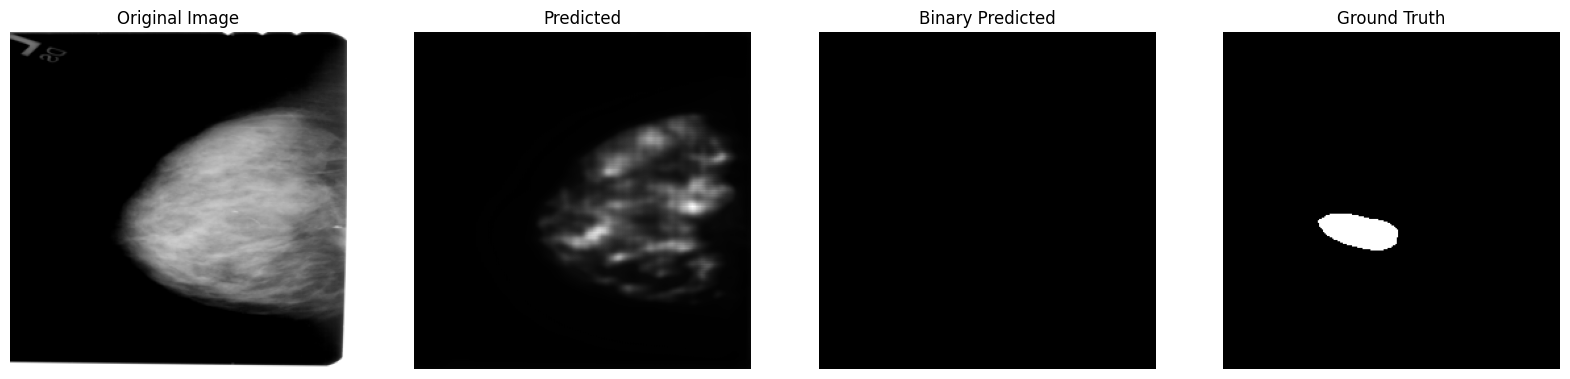

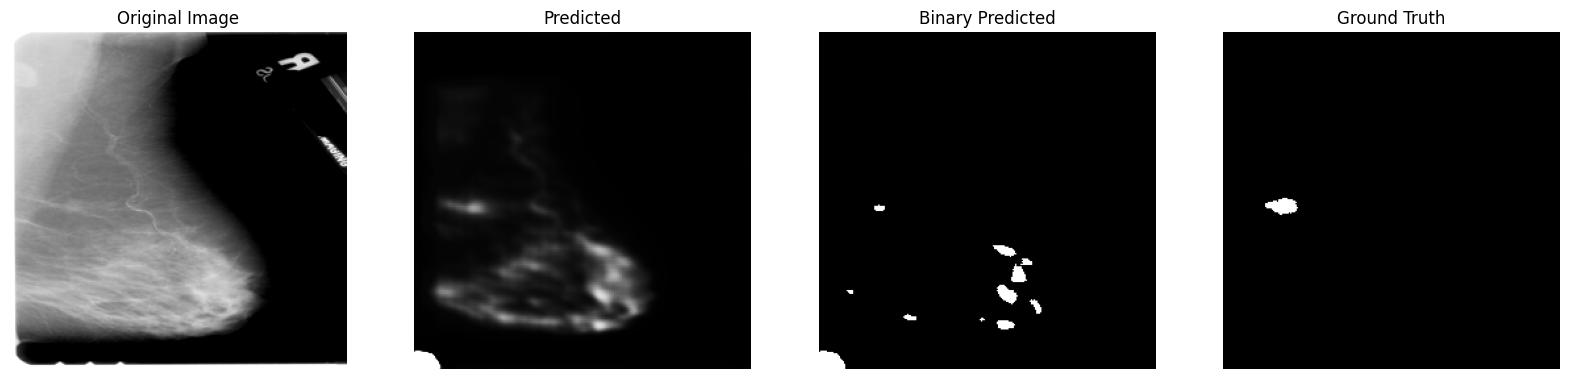

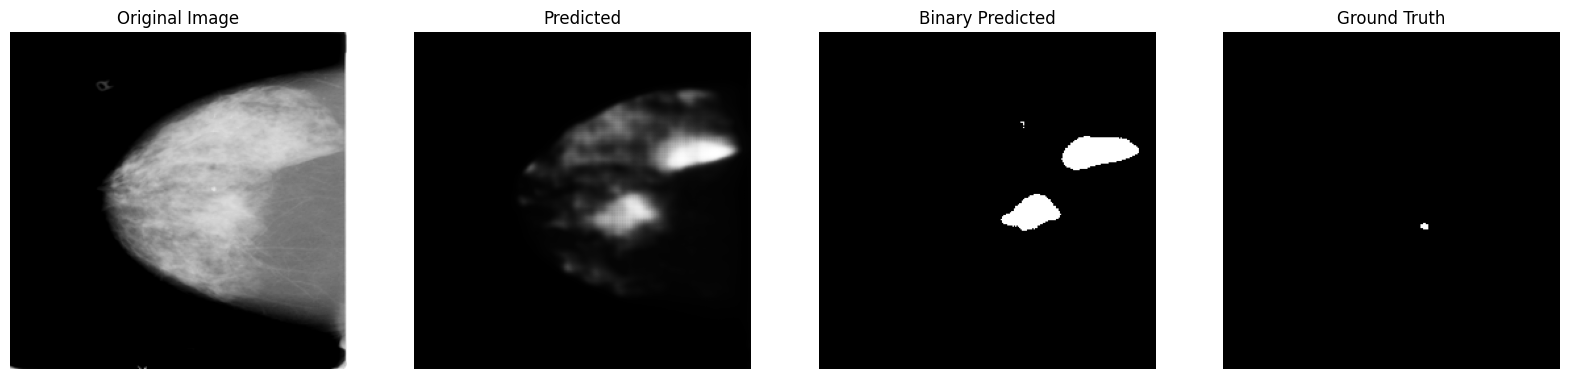

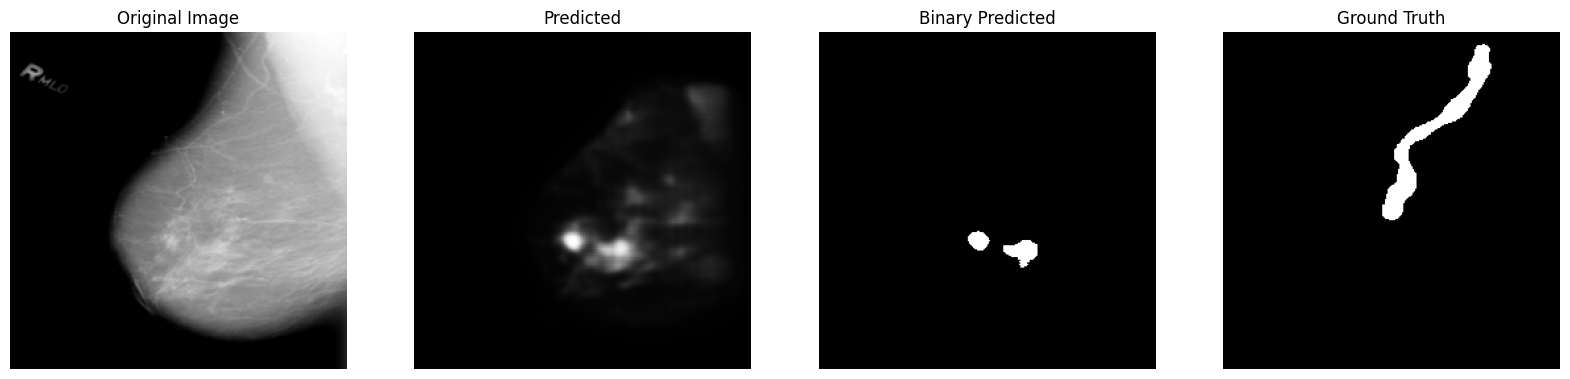

(<keras.engine.functional.Functional at 0x7fbfd0e8b250>,
 <keras.callbacks.History at 0x7fbfd0ec4f70>)

In [ ]:
train("dice_opt2",opt = optimizer(lr_schedule()), loss = dice_loss)

In [1]:
train("dice2_opt2",opt = optimizer(0.0001), loss = dice_loss2)

NameError: ignored

##using iou_loss

optimizer 1

In [ ]:
train("iou_opt1",opt = optimizer(0.001), loss = iou_loss1)

optimizer 2

In [ ]:
train("iou_opt2",opt = optimizer(lr_schedule()), loss = iou_loss1)

##using focal loss

In [ ]:
#optimizor 1 
train("focal_opt1",opt = optimizer(0.001), loss = focal_loss)

In [ ]:
#optimizer 2
train("focal_opt2",opt = optimizer(lr_schedule()), loss = focal_loss)

##dice loss combined with iou coeff 


 Model is training

Epoch 1: val_loss improved from inf to -0.08199, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt1.h5

Epoch 2: val_loss improved from -0.08199 to -0.10562, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt1.h5

Epoch 3: val_loss did not improve from -0.10562

Epoch 4: val_loss improved from -0.10562 to -0.13299, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt1.h5

Epoch 5: val_loss did not improve from -0.13299

Epoch 6: val_loss improved from -0.13299 to -0.14021, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt1.h5

Epoch 7: val_loss improved from -0.14021 to -0.14666, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt1.h5

Epoch 8: val_loss did not improve from -0.14666

Epoch 9: val_loss did not improve from -0.14666

Epoch 10: val_loss did not improve from -0.14666

Epoch 11: val_loss did not improve from -0.14666

Epoch 12: val_loss did not i

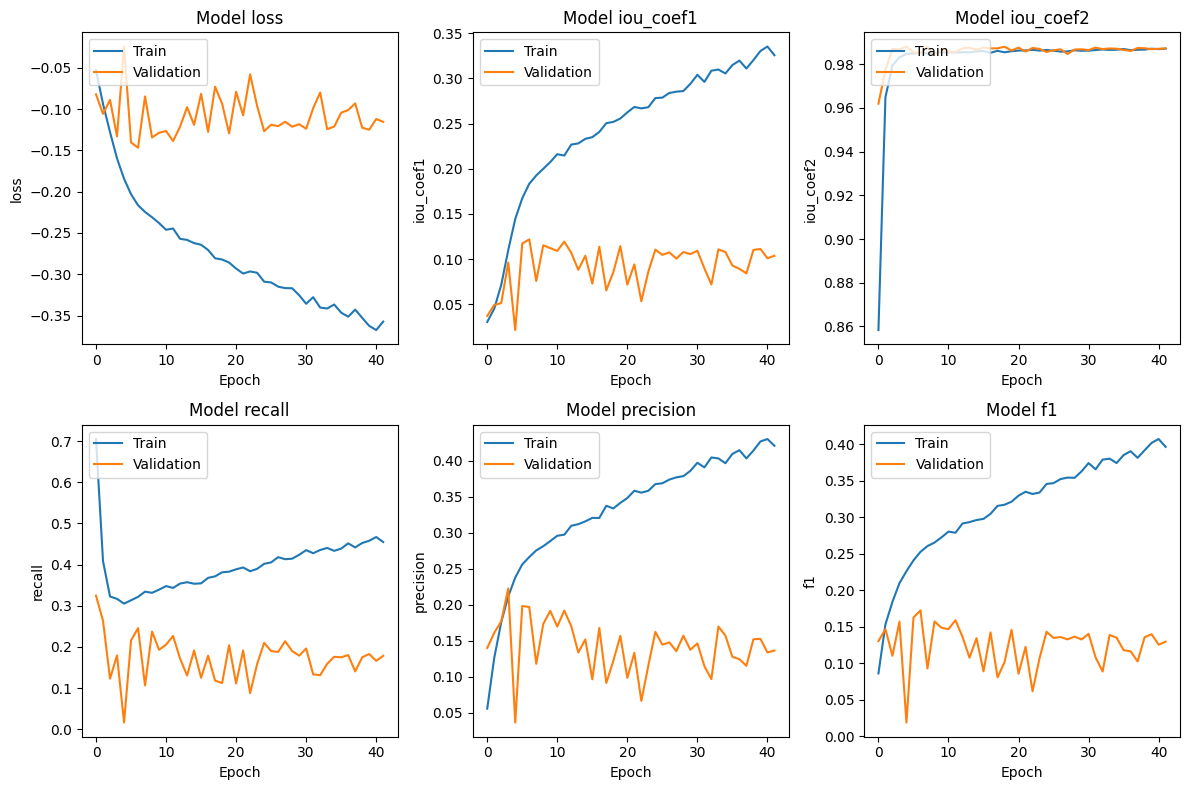



 predicting on a test set
23/23 [==============================] - 12s 257ms/step

 plotting a sample of the predicted output


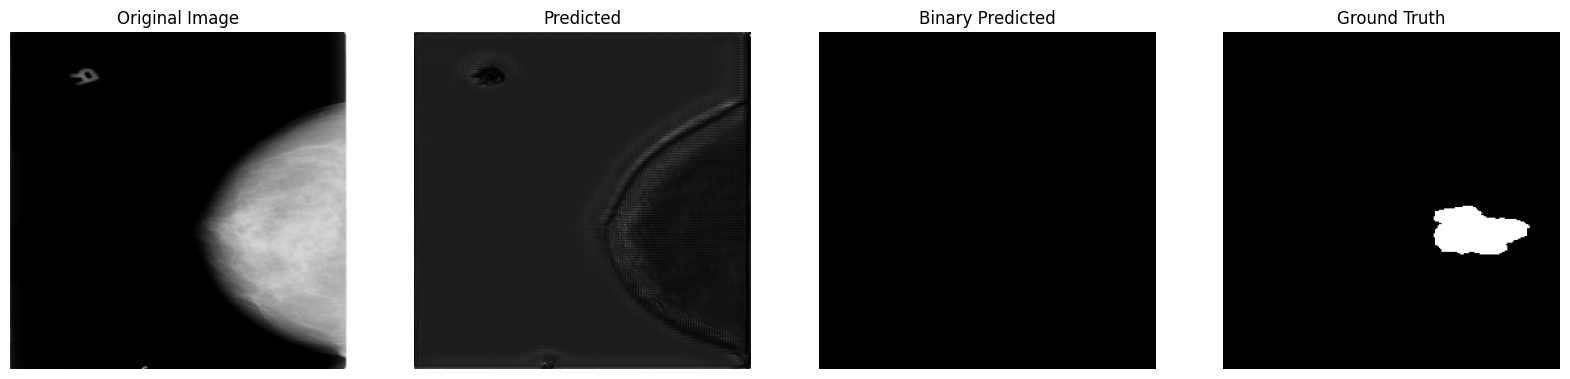

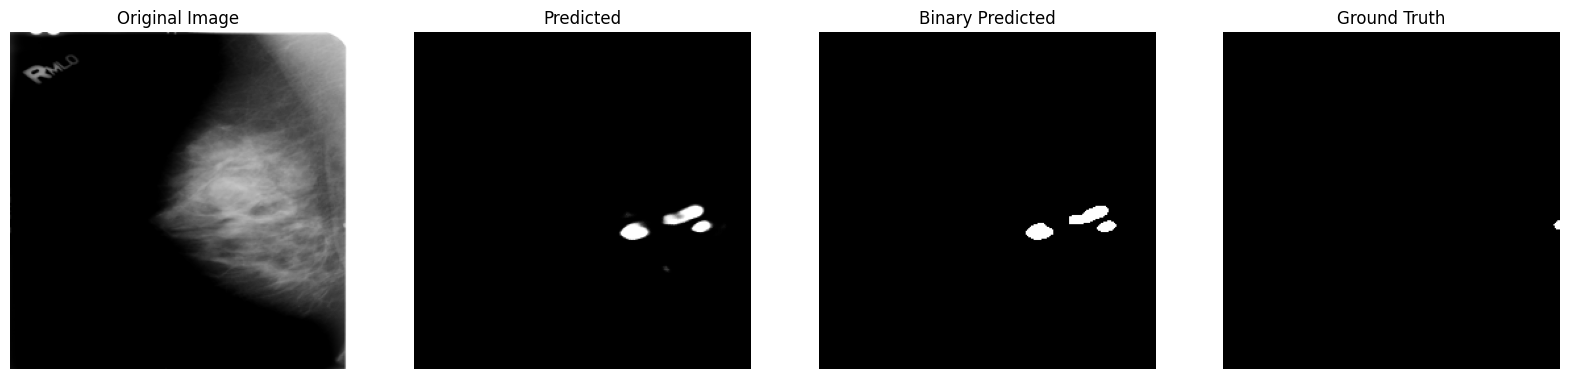

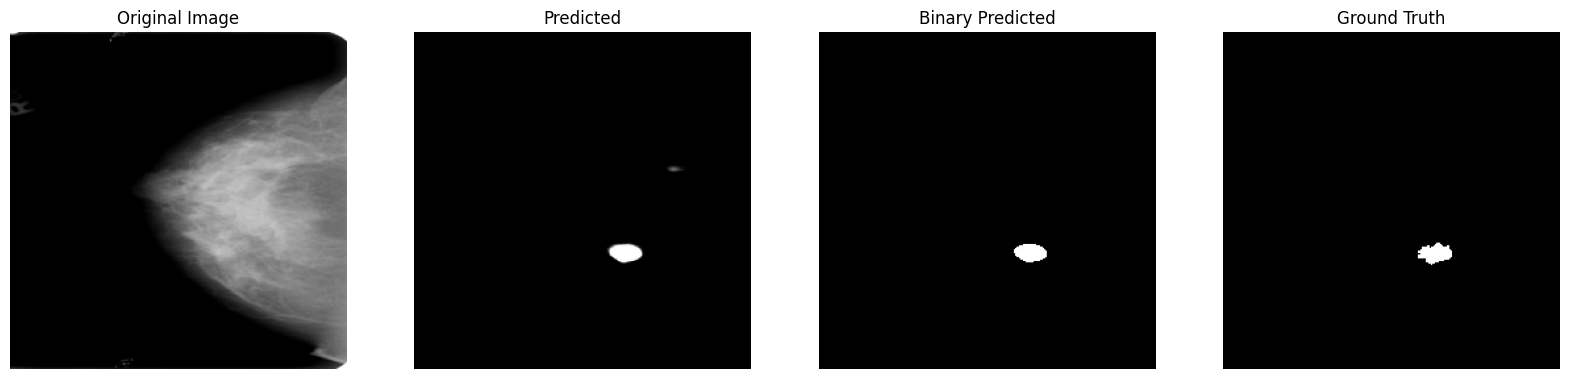

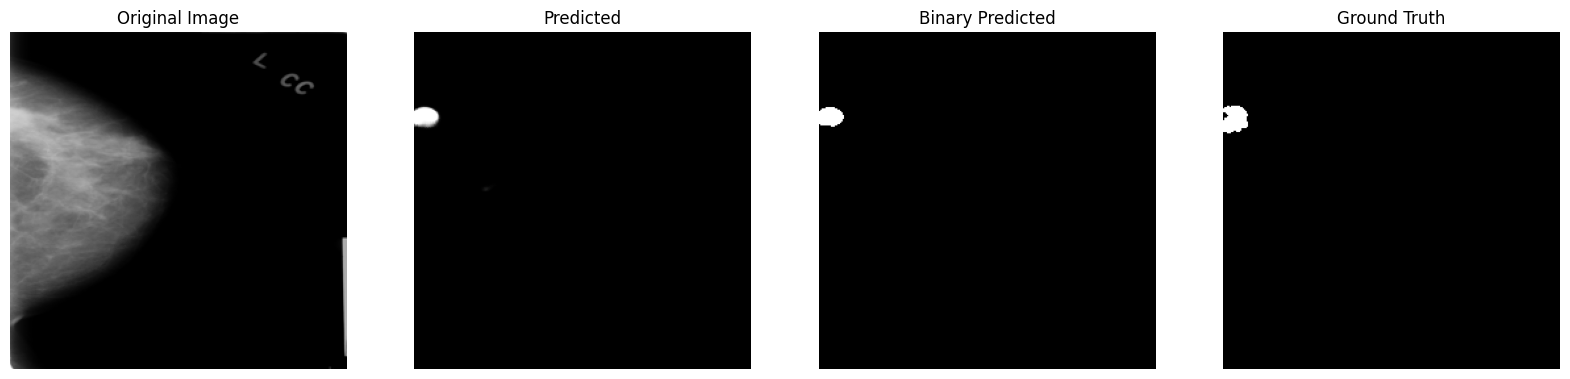

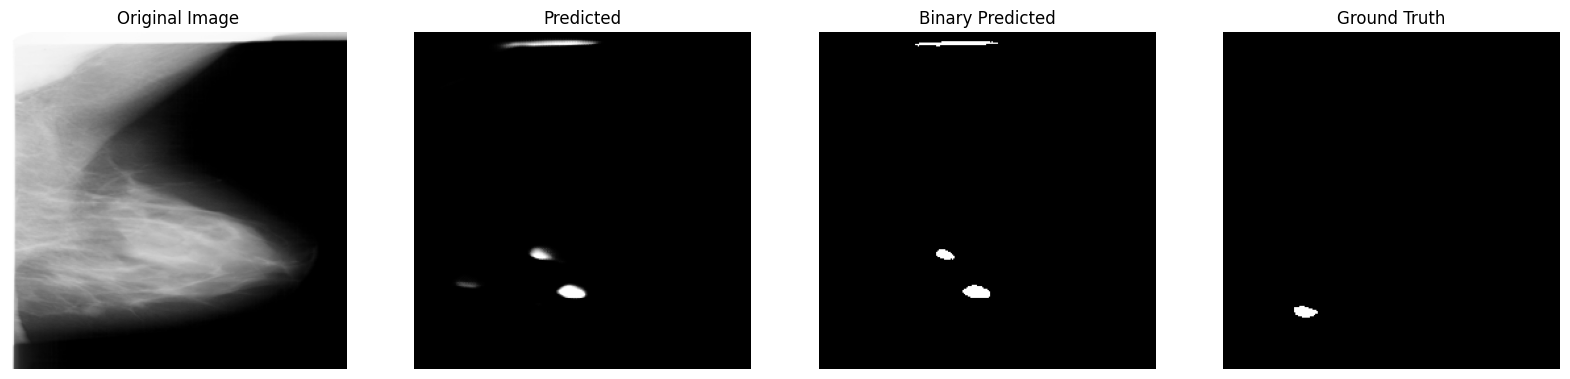

In [26]:
model1, hist1 = train("iou_dice_opt1",opt = optimizer(0.0001), loss = loss2)


 Model is training

Epoch 1: val_loss improved from inf to -0.07030, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt2.h5

Epoch 2: val_loss improved from -0.07030 to -0.07156, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt2.h5

Epoch 3: val_loss improved from -0.07156 to -0.07701, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt2.h5

Epoch 4: val_loss improved from -0.07701 to -0.07740, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt2.h5

Epoch 5: val_loss improved from -0.07740 to -0.08246, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt2.h5

Epoch 6: val_loss improved from -0.08246 to -0.08422, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt2.h5

Epoch 7: val_loss improved from -0.08422 to -0.08705, saving model to /content/drive/MyDrive/trained_models/U-Net/iou_dice_opt2.h5

Epoch 8: val_loss improved from -0.08705 to -0.08810, saving

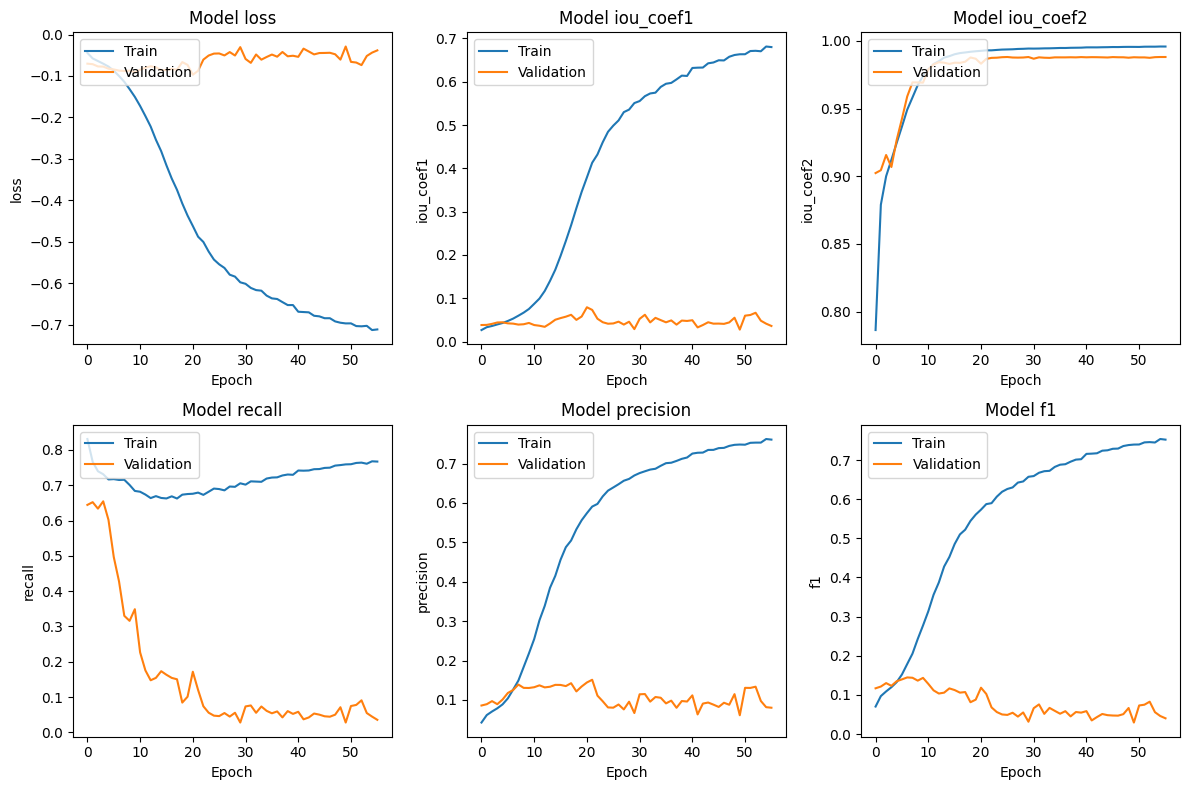



 predicting on a test set
23/23 [==============================] - 4s 161ms/step

 plotting a sample of the predicted output


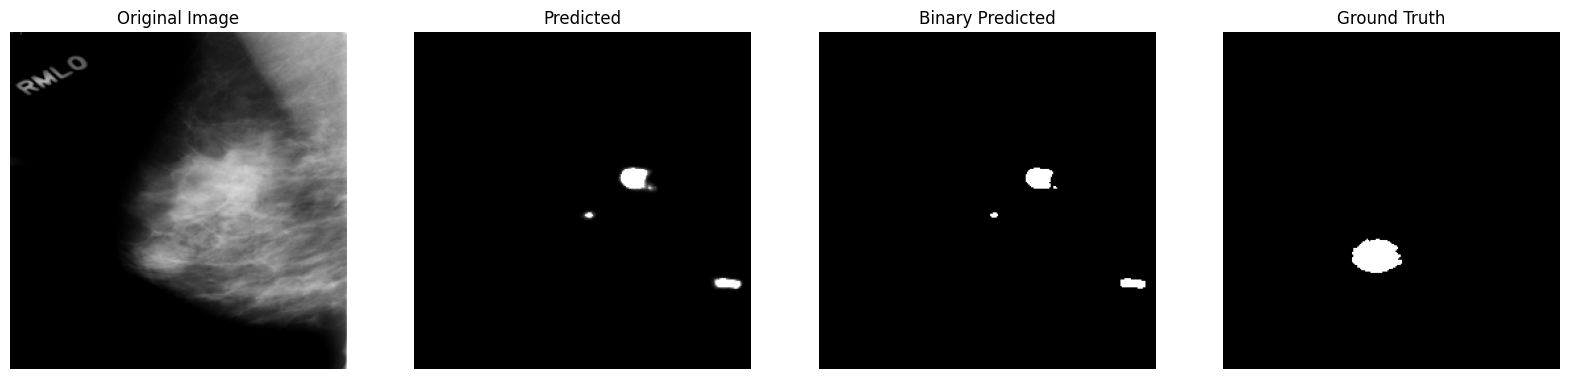

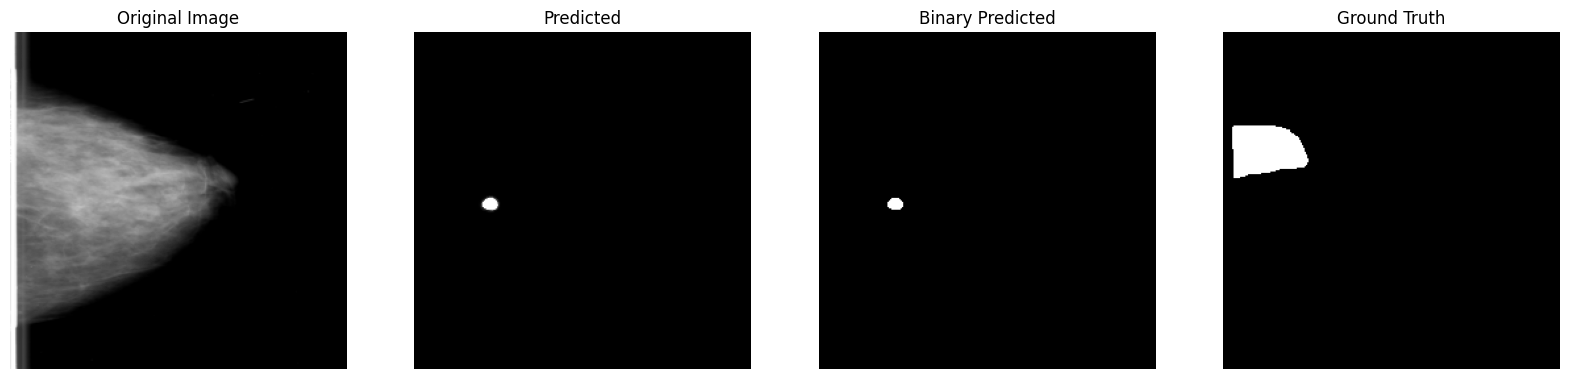

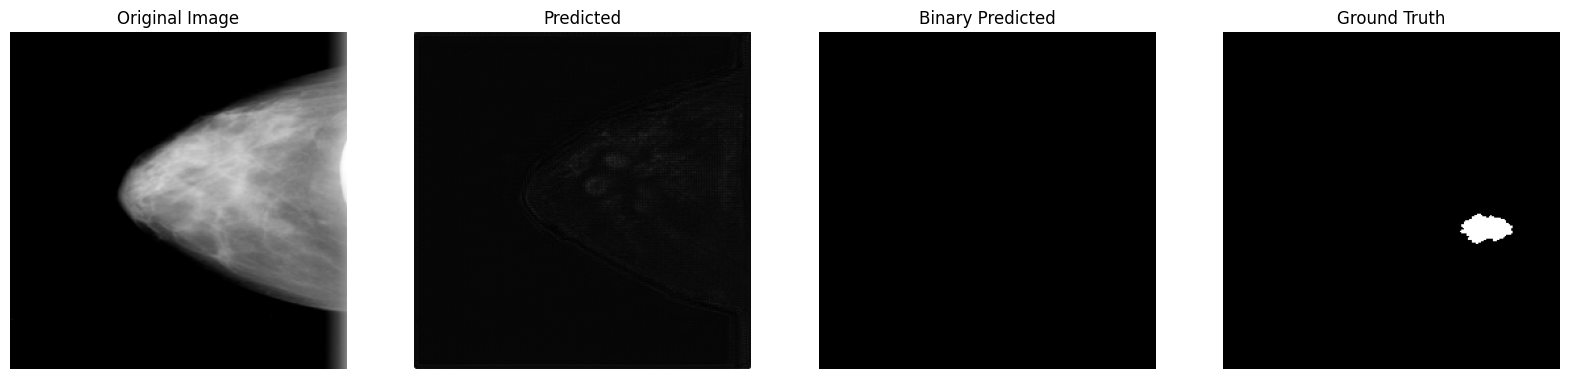

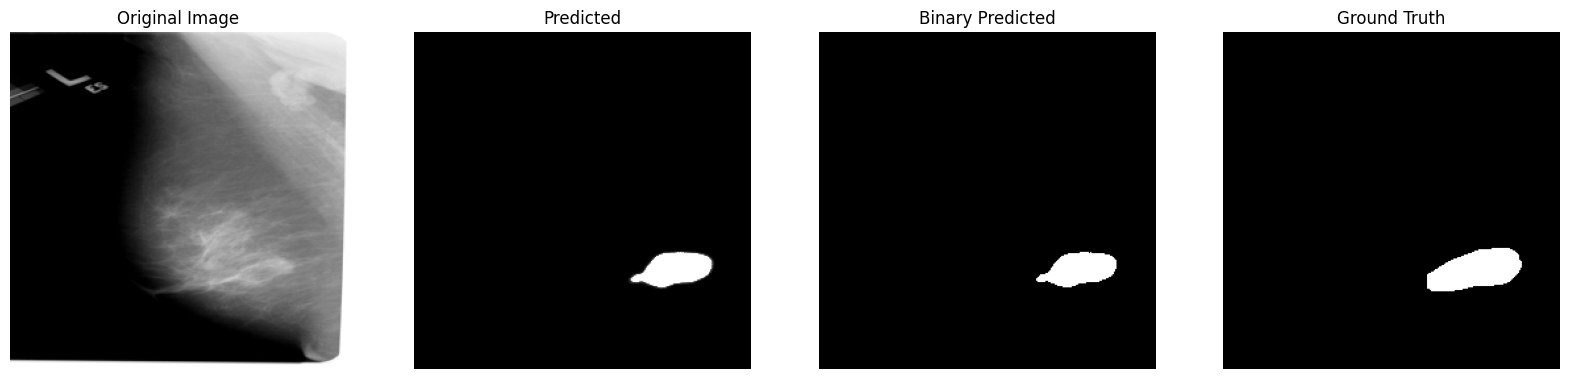

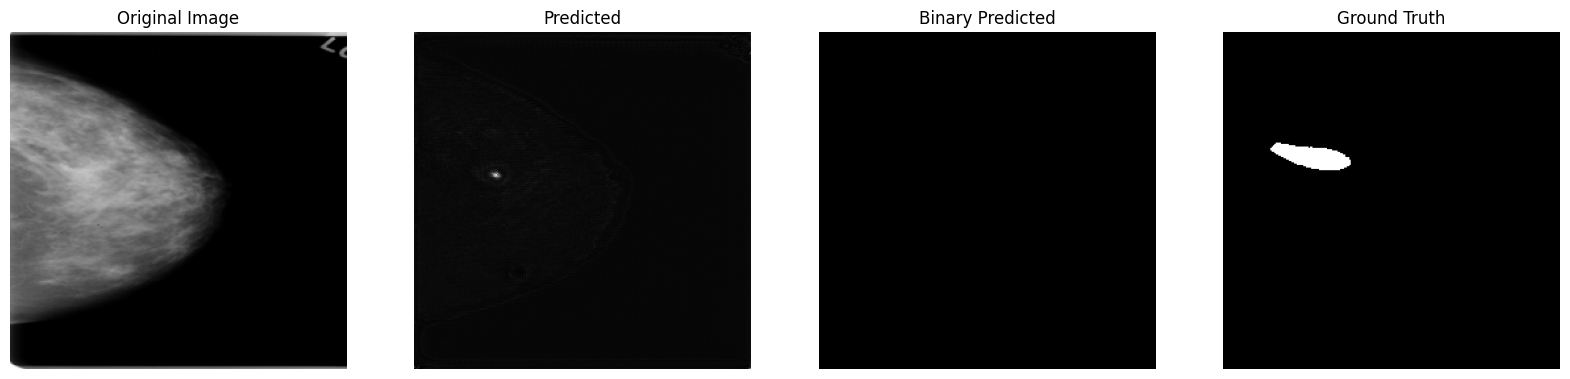

In [ ]:
model2, hist2 = train("iou_dice_opt2",opt = optimizer(0.00001), loss = loss2)

In [ ]:
model3, hist3 = train("iou_dice_opt3",opt = optimizer(0.001), loss = loss2)

In [ ]:
model4, hist4 = train("iou_dice_opt4",opt = optimizer(lr_schedule()), loss = loss2)

In [ ]:
model4, hist4 = train("iou_dice_opt3_64",opt = optimizer(0.0001), loss = loss2,star_neurons=64)

In [ ]:
model4, hist4 = train("iou_dice_opt3_16",opt = optimizer(0.0001), loss = loss2,star_neurons=16)

In [ ]:
model4, hist4 = train("iou_dice_opt3_b8",opt = optimizer(lr_schedule()), loss = loss2,batch_size = 8)

In [ ]:
model5, hist5 = train("iou_dice_opt_b16",opt = optimizer(lr_schedule()), loss = loss2, batch_size = 16)

##best 

##dice loss combined with binary crossentropy

In [ ]:
train("bi_dice_opt1",opt = optimizer(0.001), loss = loss1)

In [ ]:
train("bi_dice_opt2",opt = optimizer(lr_schedule()), loss = loss1)

##Prediction

**prediction**